In [1]:
# import required libraries 
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

from numpy import array

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import gc

from scipy import stats

import warnings
import logictensornetworks as ltn
warnings.filterwarnings("ignore")

get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
df1 = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/CICIDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", skipinitialspace = True)


df2 = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/CICIDS2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", skipinitialspace = True)




dataset = pd.concat([df1,df2]).drop_duplicates(keep=False)
dataset.reset_index(drop=True, inplace = True)

In [3]:
col_names = [col.replace(' ', '') for col in dataset.columns]
dataset.columns = col_names
dataset.head()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
label_names = dataset['Label'].unique()

import re

label_names = [re.sub("[^a-zA-Z ]+", "", l) for l in label_names]
label_names = [re.sub("[\s\s]", '_', l) for l in label_names]
label_names = [lab.replace("__", "_") for lab in label_names]

label_names, len(label_names)

(['BENIGN', 'DDoS', 'PortScan'], 3)

In [5]:
labels = dataset['Label'].unique()

for i in range(0,len(label_names)):
    dataset['Label'] = dataset['Label'].replace({labels[i] : label_names[i]})
    
dataset['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan'], dtype=object)

In [6]:
dataset.dropna(inplace=True)

In [7]:
labl = dataset[['Label']]
dataset = dataset.loc[:, dataset.columns != 'Label'].astype('float64')

In [8]:
dataset = dataset.replace([np.inf, -np.inf], np.nan)

In [9]:
dataset = dataset.merge(labl, how='outer', left_index=True, right_index=True)

In [10]:
dataset.dropna(inplace=True)

In [11]:
dataset.columns

Index(['DestinationPort', 'FlowDuration', 'TotalFwdPackets',
       'TotalBackwardPackets', 'TotalLengthofFwdPackets',
       'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
       'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
       'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd',
       'FlowBytes/s', 'FlowPackets/s', 'FlowIATMean', 'FlowIATStd',
       'FlowIATMax', 'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd',
       'FwdIATMax', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd',
       'BwdIATMax', 'BwdIATMin', 'FwdPSHFlags', 'BwdPSHFlags', 'FwdURGFlags',
       'BwdURGFlags', 'FwdHeaderLength', 'BwdHeaderLength', 'FwdPackets/s',
       'BwdPackets/s', 'MinPacketLength', 'MaxPacketLength',
       'PacketLengthMean', 'PacketLengthStd', 'PacketLengthVariance',
       'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount',
       'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount',
       '

In [12]:
dataset.Label.value_counts()

BENIGN      212718
DDoS        128005
PortScan     57305
Name: Label, dtype: int64

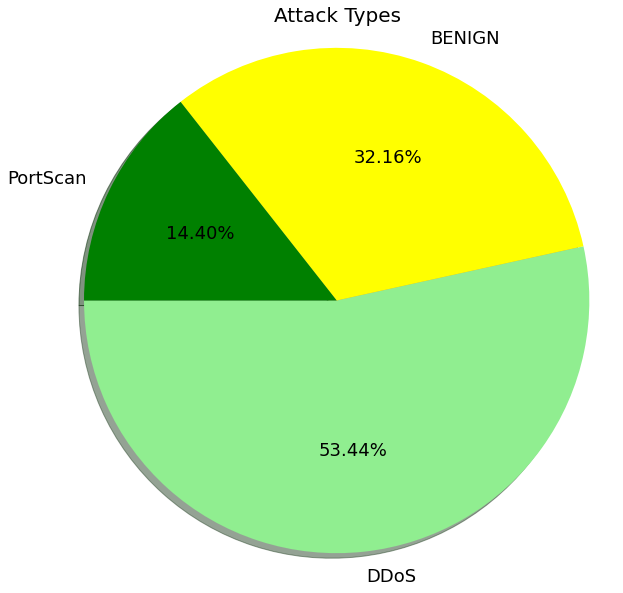

In [22]:

import matplotlib.pyplot as plt

labels= ['DDoS', 'BENIGN', 'PortScan']

colors=['lightgreen', 'yellow', 'green']

x= [212718, 128005, 57305]
explode = [0, 0, 0]
fig, ax = plt.subplots()
ax.pie(x, labels = labels,
          textprops={'fontsize': 18},
          colors = colors,
          autopct='%.2f%%',
          explode = explode,
          shadow = True,
          startangle = 180)
fig = plt.gcf()
fig.set_size_inches(10,10) # or (4,4) or (5,5) or whatever
plt.title('Attack Types', fontsize = 20)
#plt.savefig('Pie_chart_multi.png')
plt.axis('equal')


plt.show()

In [13]:
features = dataset.loc[:, dataset.columns != 'Label'].astype('float64')

In [14]:
labels=pd.DataFrame()
labels["Label"] = dataset['Label']
features = dataset.loc[:, dataset.columns != 'Label'].astype('float64')

In [15]:
scaler = RobustScaler()
scaler.fit(features)

features = scaler.transform(features)

In [16]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

LE.fit(labels["Label"])
labels["Label"] = LE.transform(labels["Label"])

In [17]:
labels.value_counts()

Label
0        212718
1        128005
2         57305
dtype: int64

In [18]:
d = LE.inverse_transform(labels["Label"])
d = pd.Series(d)
d.unique()

array(['BENIGN', 'DDoS', 'PortScan'], dtype=object)

In [19]:
# from imblearn.over_sampling import SMOTE
# smt = SMOTE()
# features, labels = smt.fit_resample(features, labels)

In [20]:
# labels_train = df_train.pop("species")
# labels_test = df_test.pop("species")
# batch_size = 64
# ds_train = tf.data.Dataset.from_tensor_slices((df_train,labels_train)).batch(batch_size)
# ds_test = tf.data.Dataset.from_tensor_slices((df_test,labels_test)).batch(batch_size)

In [21]:
from sklearn.model_selection import train_test_split

# The next step is to split training and testing data. For this we will use sklearn function train_test_split().
#label_label = labels[]
label_label = labels["Label"]

features_train, features_test, labels_train, labels_test = train_test_split(features, label_label, test_size=.2)

features_train.shape, features_test.shape, labels_train.shape, labels_test.shape

((318422, 78), (79606, 78), (318422,), (79606,))

In [22]:
import tensorflow as tf
batch_size=10000
#label_label = labels["Label"]

ds_train = tf.data.Dataset.from_tensor_slices((features_train,labels_train)).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((features_test,labels_test)).batch(batch_size)

Metal device set to: Apple M1


2022-05-20 19:21:41.069269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-20 19:21:41.069765: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
labels

,Label
0,0
1,0
2,0
3,0
4,0
...,...
398363,0
398364,0
398365,0
398366,0


In [24]:
class MLP(tf.keras.Model):
    """Model that returns logits."""
    def __init__(self, n_classes, hidden_layer_sizes=(78,67,67)):
        super(MLP, self).__init__()
        self.denses = [tf.keras.layers.Dense(s, activation="tanh") for s in hidden_layer_sizes]
        self.dense_class = tf.keras.layers.Dense(n_classes)
        self.dropout = tf.keras.layers.Dropout(0.2)
        
    def call(self, inputs, training=False):
        x = inputs
        for dense in self.denses:
            x = dense(x)
            x = self.dropout(x, training=training)
        return self.dense_class(x)

logits_model = MLP(4)
p = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model,single_label=True))

In [25]:
class_A = ltn.Constant(0, trainable=False)
class_B = ltn.Constant(1, trainable=False)
class_C = ltn.Constant(2, trainable=False)

In [26]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")

In [27]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

@tf.function
def axioms(features, labels, training=False):
    x_A = ltn.Variable("x_A",features[labels==0])
    x_B = ltn.Variable("x_B",features[labels==1])
    x_C = ltn.Variable("x_C",features[labels==2])
    axioms = [
        Forall(x_A,p([x_A,class_A],training=training)),
        Forall(x_B,p([x_B,class_B],training=training)),
        Forall(x_C,p([x_C,class_C],training=training))
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

In [28]:
for features, labels in ds_test:
    print("Initial sat level %.5f"%axioms(features,labels))
    break

2022-05-20 19:21:42.074269: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-20 19:21:42.074778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Initial sat level 0.23601


In [29]:
metrics_dict = {
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'test_sat_kb': tf.keras.metrics.Mean(name='test_sat_kb'),
    'train_accuracy': tf.keras.metrics.CategoricalAccuracy(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")
}

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function
def train_step(features, labels):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(features, labels, training=True)
        loss = 1.-sat
    gradients = tape.gradient(loss, p.trainable_variables)
    optimizer.apply_gradients(zip(gradients, p.trainable_variables))
    sat = axioms(features, labels) # compute sat without dropout
    metrics_dict['train_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['train_accuracy'](tf.one_hot(labels,3),predictions)
    
@tf.function
def test_step(features, labels):
    # sat
    sat = axioms(features, labels)
    metrics_dict['test_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['test_accuracy'](tf.one_hot(labels,3),predictions)

In [31]:
from collections import defaultdict

def train(
        epochs,
        metrics_dict, 
        ds_train, 
        ds_test, 
        train_step, 
        test_step,
        track_metrics=1,
        csv_path=None,
        scheduled_parameters=defaultdict(lambda : {})
    ):
    """
    Args:
        epochs: int, number of training epochs.
        metrics_dict: dict, {"metrics_label": tf.keras.metrics instance}.
        ds_train: iterable dataset, e.g. using tf.data.Dataset.
        ds_test: iterable dataset, e.g. using tf.data.Dataset.
        train_step: callable function. the arguments passed to the function
            are the itered elements of ds_train.
        test_step: callable function. the arguments passed to the function
            are the itered elements of ds_test.
        csv_path: (optional) path to create a csv file, to save the metrics.
        scheduled_parameters: (optional) a dictionary that returns kwargs for
            the train_step and test_step functions, for each epoch.
            Call using scheduled_parameters[epoch].
    """
    template = "Epoch {}"
    for metrics_label in metrics_dict.keys():
        template += ", %s: {:.4f}" % metrics_label
    if csv_path is not None:
        csv_file = open(csv_path,"w+")
        headers = ",".join(["Epoch"]+list(metrics_dict.keys()))
        csv_template = ",".join(["{}" for _ in range(len(metrics_dict)+1)])
        csv_file.write(headers+"\n")
    
    for epoch in range(epochs):
        for metrics in metrics_dict.values():
            metrics.reset_states()

        for batch_elements in ds_train:
            train_step(*batch_elements,**scheduled_parameters[epoch])
        for batch_elements in ds_test:
            test_step(*batch_elements,**scheduled_parameters[epoch])

        metrics_results = [metrics.result() for metrics in metrics_dict.values()]
        if epoch%track_metrics == 0:
            print(template.format(epoch,*metrics_results))
        if csv_path is not None:
            csv_file.write(csv_template.format(epoch,*metrics_results)+"\n")
            csv_file.flush()
    if csv_path is not None:
        csv_file.close()

In [32]:
EPOCHS = 100

train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="results_final_tanh_batchmare.csv",
    track_metrics=1
)

2022-05-20 19:21:42.979515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-20 19:21:52.218401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-20 19:21:53.206405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-20 19:21:54.295255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 0, train_sat_kb: 0.6315, test_sat_kb: 0.7588, train_accuracy: 0.7972, test_accuracy: 0.8956
Epoch 1, train_sat_kb: 0.7849, test_sat_kb: 0.8111, train_accuracy: 0.9081, test_accuracy: 0.9229
Epoch 2, train_sat_kb: 0.8129, test_sat_kb: 0.8198, train_accuracy: 0.9247, test_accuracy: 0.9461
Epoch 3, train_sat_kb: 0.8113, test_sat_kb: 0.7989, train_accuracy: 0.9244, test_accuracy: 0.9220
Epoch 4, train_sat_kb: 0.8118, test_sat_kb: 0.8240, train_accuracy: 0.9241, test_accuracy: 0.9276
Epoch 5, train_sat_kb: 0.8093, test_sat_kb: 0.7979, train_accuracy: 0.9240, test_accuracy: 0.9254
Epoch 6, train_sat_kb: 0.8055, test_sat_kb: 0.8054, train_accuracy: 0.9222, test_accuracy: 0.9217
Epoch 7, train_sat_kb: 0.8141, test_sat_kb: 0.8263, train_accuracy: 0.9213, test_accuracy: 0.9222
Epoch 8, train_sat_kb: 0.8115, test_sat_kb: 0.8130, train_accuracy: 0.9263, test_accuracy: 0.9265
Epoch 9, train_sat_kb: 0.8119, test_sat_kb: 0.8130, train_accuracy: 0.9248, test_accuracy: 0.9264
Epoch 10, train_sat_

Text(27.125, 0.5, 'Satisfiability')

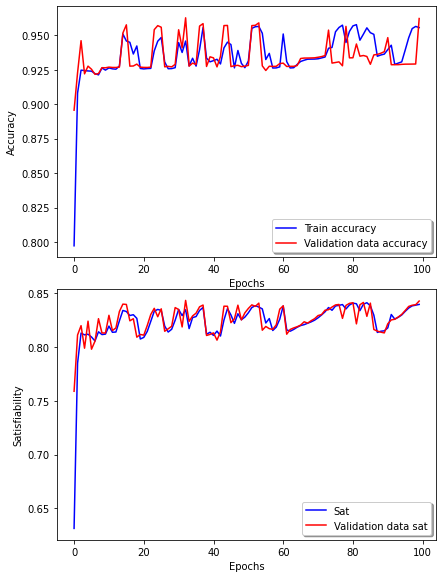

In [35]:
from pylab import rcParams
import matplotlib
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 6, 8

results = pd.read_csv("results_final_tanh_batchmare.csv", skipinitialspace = True)
fig, ax = plt.subplots(2,1)
fig.tight_layout()
#figure(figsize=(10, 6), dpi=150)
ax[0].plot(results['train_accuracy'], color='b', label="Train accuracy")
ax[0].plot(results['test_accuracy'], color='r', label="Validation data accuracy",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(results['train_sat_kb'], color='b', label="Sat")
ax[1].plot(results['test_sat_kb'], color='r',label="Validation data sat")
legend = ax[1].legend(loc='best', shadow=True)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Satisfiability')

